In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os 
import sys
sys.path.append(os.path.abspath('../..'))

# Merging PV Values and Weather Data together

In [2]:
def preprocess_weather(df):
    """ 
    Scales the weather data and extracts the relevant time interval.
    Keeps only neccessary columns.
    """
     # Convert the column to datetime format
    df["validdate"] = pd.to_datetime(df["validdate"])
    df['datetime'] = df['validdate'].dt.strftime('%Y-%m-%d %H:%M:%S')

    # Extract the date and time components into separate columns
    df["time"] = df["validdate"].dt.strftime("%H:%M")
    # keep only values where time is between 08:00 and 16:00
    df = df[(df['time'] >= '08:00') & (df['time'] <= '15:00')]
    df = df.drop(columns=['validdate', 'time'], axis=1)

    # standardise the data
    for col in df.columns:
        if col in ['datetime', 'lat', 'lon']:
            continue

        df[col] = (df[col]  - df[col].min())/ (df[col].max() - df[col].min())

    return df

def load_weather_data():
    # get path to directory
    current_directory = os.getcwd().split("Dissertation")[0] + 'pv_data/weather_data'
    # get list of files in directory
    files = os.listdir(current_directory)
    # remove DS_Store file
    files.pop(0)
    # sort files
    files.sort()

    df_dict = {}
    for file in files:
        path_to_file = os.path.join(current_directory, file)
        df = pd.read_csv(path_to_file, sep=';')
        df = preprocess_weather(df)
        df_dict[file] = df
    
    return df_dict    

In [3]:
df_dict = load_weather_data()

In [4]:
df_list = [df for df in df_dict.values()]
df_weather = pd.concat(df_list, axis=0)

In [5]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 400
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 500
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [6]:
from data import PVDataGenerator
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=POLY_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='poly',
                    drop_nan=False)

==> Loading data
==> Loaded data in: 0 m : 5 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec

Found system at (53.36, -2.84)
Found system at (51.42, -3.26)
Found system at (54.97, -2.46)
Found system at (57.15, -2.5)
Found system at (55.54, -3.68)
Found system at (55.62, -3.02)
Found system at (55.63, -4.64)
Found system at (53.29, -3.7)
Found system at (53.59, -2.17)
Found system at (53.33, -2.99)
Found system at (54.52, -1.36)
Found system at (54.8, -1.57)
Found system at (51.78, -3.21)
Found system at (55.45, -4.52)
Found system at (55.95, -4.82)
Found system at (54.9, -1.45)
Found system at (54.54, -1.3)
Found system at (52.04, -3.93)
Found system at (56.34, -3.41)
Found system at (57.37, -2.09)
Found system at (53.16, -2.63)
Found system at (57.71, -3.43)
Found system at (54.64, -3.56)
Found system at (57.16, -2.28)
Found system at (57.63, -3.31)
Found system at (53.21, -3.07)
Found system at (51.73, -4.31)
Found system at (55.66, -4.72)
Found system at (55.92, -4.65)
Found 

In [7]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

In [8]:
df_pv = generator.pv_series
df_pv['month'] = df_pv['datetime'].dt.month
df_pv['season'] = df_pv['datetime'].dt.month.apply(lambda x: get_season(x))
df_pv = df_pv.drop(['epoch', 'farm'], axis=1)

In [9]:
def merge_weather_and_pv(df_weather, df_pv):
    # Convert 'datetime' columns to datetime type if not already done
    df_pv['datetime'] = pd.to_datetime(df_pv['datetime'])
    df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

    # get the data in df_pv that has the latitude longitude pairs from unique_coords
    unique_coords = df_weather[['lat', 'lon']].drop_duplicates()
    merged_dataframes = []

    for index, row in unique_coords.iterrows():
        lat, lon = row['lat'], row['lon']
        pv_test = df_pv[(df_pv['latitude'] == lat) & (df_pv['longitude'] == lon)]
        weather_test = df_weather[(df_weather['lat'] == lat) & (df_weather['lon'] == lon)]
       # weather_test = weather_test.drop(['lat', 'lon'], axis=1)

        # Merge the two data frames on the 'datetime' column
        merged_df = weather_test.merge(pv_test, on='datetime')
        # drop nan values if any by row
        merged_df = merged_df.dropna(axis=0)
        merged_dataframes.append(merged_df)

    # Concatenate all the merged data frames into a single data frame
    final_merged_df = pd.concat(merged_dataframes, ignore_index=True)
    
    return final_merged_df



In [10]:
df = merge_weather_and_pv(df_weather=df_weather, df_pv=df_pv)

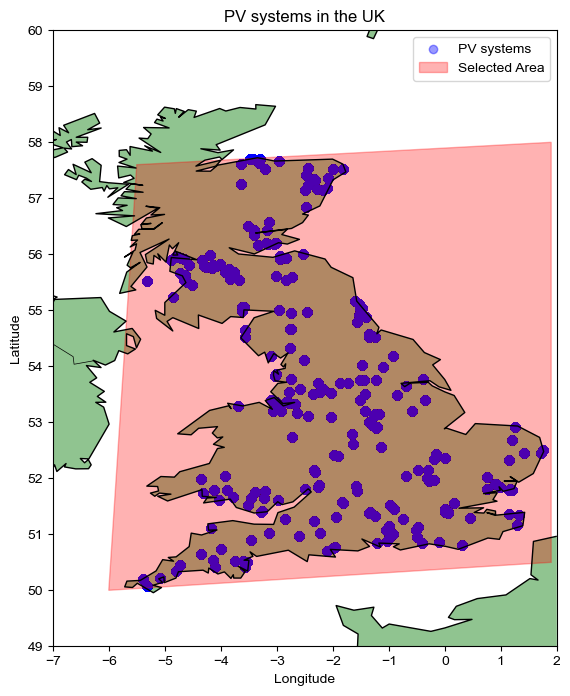

In [11]:
from pv_plot import plot_grid
plot_grid(df, POLY_COORDS, distance_method='poly')

In [12]:
from data.utils import save_csv
save_csv(df, folder_name='pv_data', file_name='pv_and_weather.csv')

In [2]:
# data parameters
DAY_INIT = 40
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 10
MINUTE_INTERVAL = 60
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 10
# create a tuple of 4 coordinates that form a polygon in the uk
# and a circle with a radius of r
CIRCLE_COORDS = (55, -1.5)
RADIUS = 0.3
POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))


In [3]:
from data import PVWeatherLoader

loader = PVWeatherLoader(
    # number of days to get data for
    n_days=N_DAYS,
    # initial day of the data for that season
    # look at the data frame to see which day it is
    day_init=DAY_INIT,
    # number of systems to extract
    n_systems=N_SYSTEMS,
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    # the minute interval our data is sampled at 
    # (e.g. 60 for hourly, 30 for half hourly, 15 for 15 minutes, etc.)
    minute_interval=MINUTE_INTERVAL,
    # the minimum and maximum hour of the day to use
    # (e.g. 8 and 15 for 8am to 3pm)
    day_min=DAY_MIN,
    day_max=DAY_MAX,
    folder_name='pv_data',
    file_name='pv_and_weather.csv',
    distance_method='circle',
    # optionally use a season
    season='winter',
    # optionally drop series with nan values
    drop_nan=False
)

==> Loading data
==> Loaded data in: 0 m : 1 sec



/Users/eirikbaekkelund/Desktop/UCL/Code/Dissertation/data/utils.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('season', axis=1, inplace=True)


# Examples of using the Weather Loader

In [4]:
# looping through each individual system
# with the specifications made above
for X, y in loader:
    print(X.shape, y.shape)
    

torch.Size([80, 5]) torch.Size([80])
torch.Size([80, 5]) torch.Size([80])
torch.Size([80, 5]) torch.Size([80])
torch.Size([80, 5]) torch.Size([80])
torch.Size([80, 5]) torch.Size([80])
torch.Size([80, 5]) torch.Size([80])
torch.Size([80, 5]) torch.Size([80])
torch.Size([80, 5]) torch.Size([80])


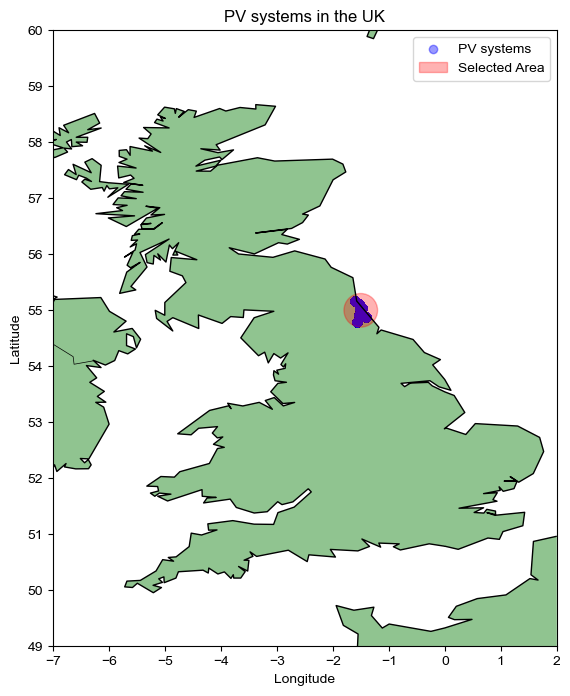

In [5]:
# getting the dataframe
from pv_plot import plot_grid
df = loader.df
plot_grid(df, coords=CIRCLE_COORDS, radius=RADIUS, distance_method='circle')

In [6]:
from gpytorch.means import ZeroMean, ConstantMean
from gpytorch.constraints import Positive
from kernels import Kernel
from models import ApproximateGPBaseModel
from likelihoods import BetaLikelihood_MeanParametrization

kernel = Kernel(num_latent=1)
matern_base = kernel.get_matern(lengthscale_constraint=Positive(),
                                outputscale_constraint=Positive())
matern_quasi = kernel.get_matern(lengthscale_constraint=Positive(),
                                 outputscale_constraint=Positive())
periodic1 = kernel.get_periodic(lengthscale_constraint= Positive(),
                                outputscale_constraint=Positive())
periodic2 = kernel.get_periodic(lengthscale_constraint= Positive(),
                                outputscale_constraint=Positive()
                                )

covar_module = kernel.get_quasi_periodic(matern_base=matern_base, 
                                    matern_quasi=matern_quasi,
                                    periodic1=periodic1,
                                    periodic2=None)
mean = ZeroMean()
likelihood = BetaLikelihood_MeanParametrization()

In [12]:
config = {
    'type' : 'stochastic',
    'name' : 'mean_field',
}
inputs ={
    'mean_module' : mean,
    'covar_module': covar_module,
    'likelihood': likelihood,
    'learn_inducing_locations': False,
}

Iter 30/300 - Loss: -1.274
Iter 60/300 - Loss: -1.345
Iter 90/300 - Loss: -1.376
Iter 120/300 - Loss: -1.398
Iter 150/300 - Loss: -1.415
Iter 180/300 - Loss: -1.428
Iter 210/300 - Loss: -1.438
Iter 240/300 - Loss: -1.445
Iter 270/300 - Loss: -1.451
Iter 300/300 - Loss: -1.455
Iter 30/300 - Loss: -0.944
Iter 60/300 - Loss: -1.146
Iter 90/300 - Loss: -1.166
Iter 120/300 - Loss: -1.176
Iter 150/300 - Loss: -1.184
Iter 180/300 - Loss: -1.191
Iter 210/300 - Loss: -1.197
Iter 240/300 - Loss: -1.202
Iter 270/300 - Loss: -1.206
Iter 300/300 - Loss: -1.210
Iter 30/300 - Loss: -1.177
Iter 60/300 - Loss: -1.339
Iter 90/300 - Loss: -1.358
Iter 120/300 - Loss: -1.367
Iter 150/300 - Loss: -1.374
Iter 180/300 - Loss: -1.381
Iter 210/300 - Loss: -1.387
Iter 240/300 - Loss: -1.392
Iter 270/300 - Loss: -1.396
Iter 300/300 - Loss: -1.399
Iter 30/300 - Loss: -0.696
Iter 60/300 - Loss: -0.891
Iter 90/300 - Loss: -0.916
Iter 120/300 - Loss: -0.925
Iter 150/300 - Loss: -0.932
Iter 180/300 - Loss: -0.937
Iter

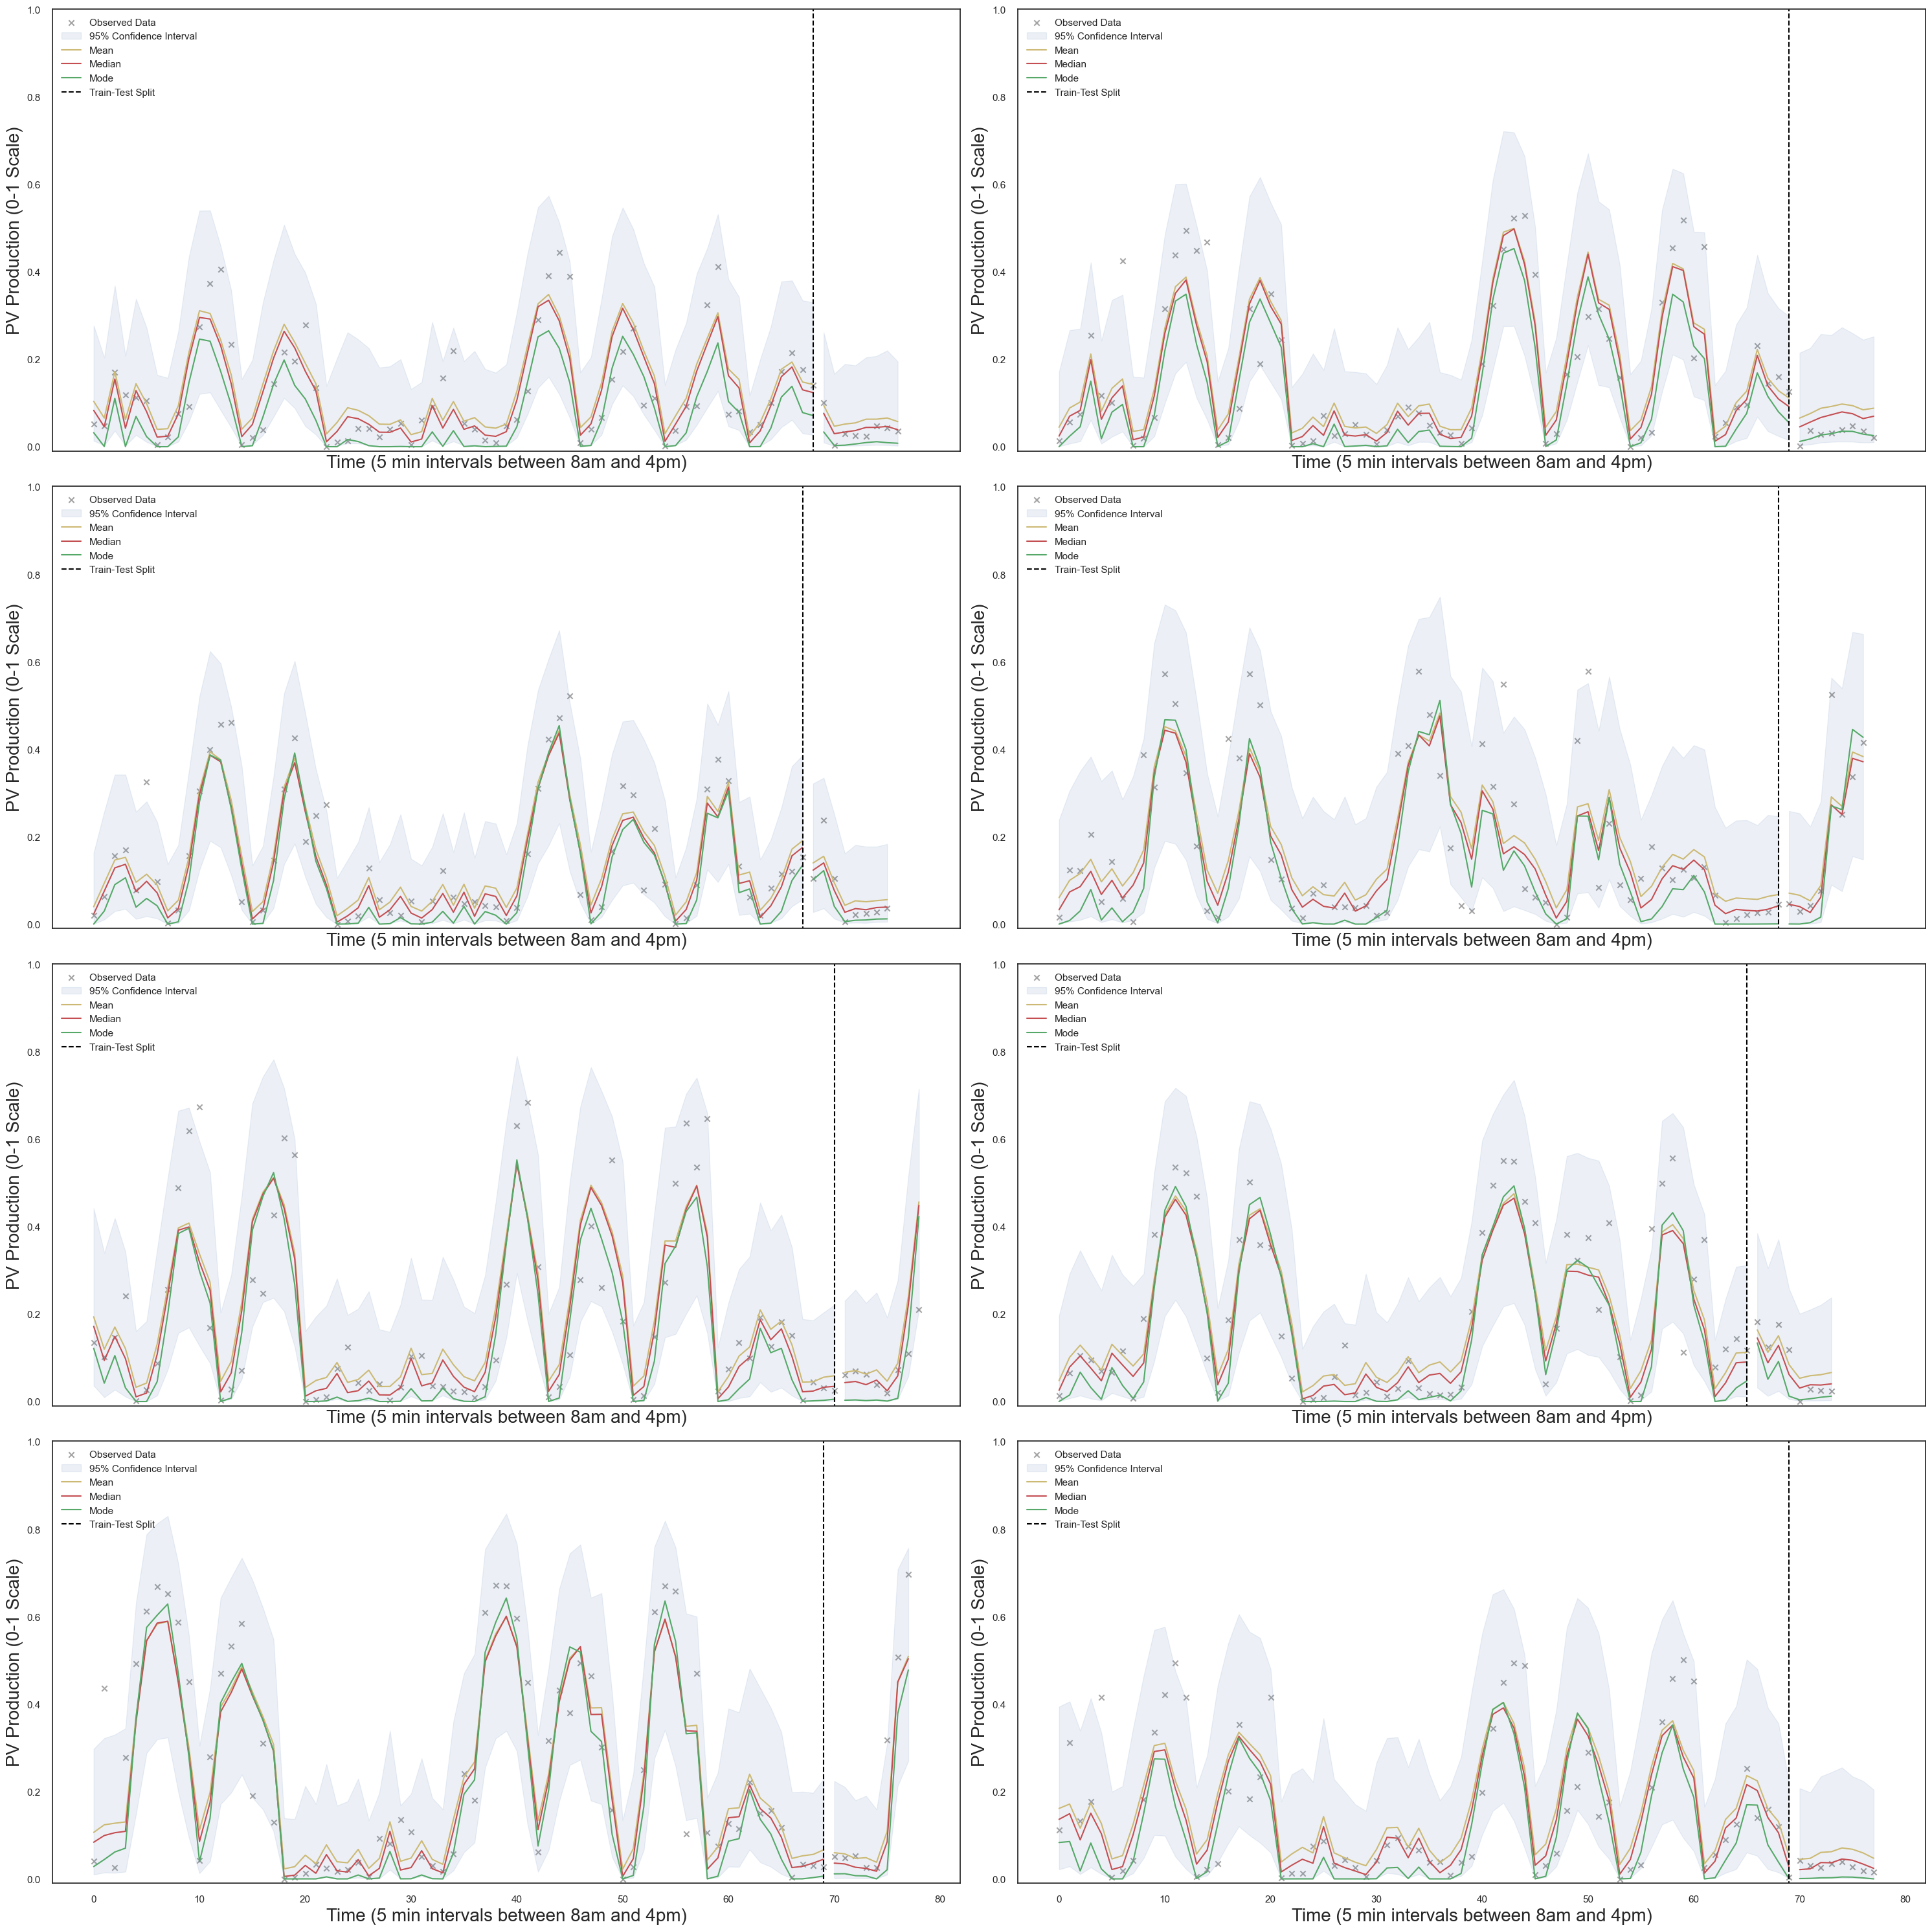

In [16]:
from data.utils import train_test_split
from pv_plot import plot_gp_ax


fig, axs = plt.subplots(len(loader) // 2, 2, figsize=(30, 30), sharex=True)
axs = axs.flatten()
plt.rcParams['font.family'] = 'Arial'

for i, (X, y) in enumerate(loader):
    
    hour = np.random.randint(8, 14)
    x_train, y_train, x_test, y_test = train_test_split(X, y, hour,minute_interval=60, day_min=8, day_max=15,  n_hours=8)
    
    config['num_inducing_points'] = x_train.size(0)
    inputs['config'] = config
    inputs['X'] = x_train
    inputs['y'] = y_train

    model = ApproximateGPBaseModel(**inputs)
    model.fit(n_iter=300, lr=0.2, verbose=True)
    plot_gp_ax(model, x_train, x_test, y_train, y_test, pred_type='all', ax=axs[i])

plt.tight_layout()